This notebook will analyze the milestoning data extracted from milestoning MD simulations (see Extract_MD_Milestoning_Data.ipynb)

The background for computing the escape matrix and corresponding equilibrium distribution is discussed here. The source code for the function that implements this can be found in the file "analysis_functions.py" (see definition for function "analyze_milestone1D_data").

If you are running this on the cloud (e.g. google colab, kaggle, etc) you will need to clone the repo. If you have not done so already. You can do this by uncommenting and running the cell below.

In [ ]:
#!git clone https://github.com/wesleymsmith/Milestoning_Analysis.git

In [ ]:
#!ln -s Milestoning_Analysis/analysis_functions.py ./

In [22]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import gc
import sys
import os
import f90nml
import itertools

import bokeh
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

from bokeh.models.mappers import CategoricalColorMapper

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import scipy as sp
from scipy.sparse import linalg

import analysis_functions

First, the data needs to be loaded from the coordinate and restraint data files. If needed, these can be found in the git repo described above.

In [4]:
dataDir='.'
#dataDir='Milestoning_Analysis' #uncomment this line if you had to clone the repo as directed above

coordDataFile='Simulation_Milestone_Coordinate_Data.csv'
restDataFile='Simulation_Milestone_Restraint_Data.csv'

simData=pd.read_csv(dataDir+'/'+coordDataFile)
restData=pd.read_csv(dataDir+'/'+restDataFile)

print simData.head()
print restData.head()

   Window  Time       X
0       0     0  15.195
1       0   500  14.744
2       0  1000  14.688
3       0  1500  14.631
4       0  2000  14.230
   W1L_r2  W1L_r3  W1L_rk2  W1L_rk3  W2L_r2  W2L_r3  W2L_rk2  W2L_rk3  Window
0   109.0   111.0      0.0      0.0    14.0    16.0    100.0    100.0       0
1   107.0   109.0      0.0      0.0    16.0    18.0    100.0    100.0       1
2   105.0   107.0      0.0      0.0    18.0    20.0    100.0    100.0       2
3   103.0   105.0      0.0      0.0    20.0    22.0    100.0    100.0       3


Next, we need to extract the centers and upper and lower bounds of each window from the restraint data table

In [5]:
winMins=restData.W2L_r2
winMaxs=restData.W2L_r3
windowCenters=(winMins+winMaxs)/2.0
print 'Window Centers:     ',
print map(lambda x: '%8.4f'%x,windowCenters)

print 'Left Window Edges:  ',
print map(lambda x: '%8.4f'%x,winMins)

print 'Right Window Edges: ',
print map(lambda x: '%8.4f'%x,winMaxs)

Window Centers:      [' 15.0000', ' 17.0000', ' 19.0000', ' 21.0000']
Left Window Edges:   [' 14.0000', ' 16.0000', ' 18.0000', ' 20.0000']
Right Window Edges:  [' 16.0000', ' 18.0000', ' 20.0000', ' 22.0000']


We are now ready to compute the escape matrix and corresponding equilibrium probabilities for being in each window.

The escape matrix is an Nwindow by Nwindow matrix with a diagonal of 0.
The off diagonals represent the probability of transitioning form one window to another.

I.e.
$$M_{i,j}=N_{i->j}/N_{i}$$
where $M_{i,j}$ is an element of the escape matrix, $N_{i->j}$ is the number of frames where $x$ is observed in bin $j$ when it was in bin $i$ on the previous frame, and $N_{i}$ is the number of frames where $x$ is observed in bin $i$ as computed from the simulation with the milestoning well for bin $i$

We then use the definition of the escape matrix to help us find the equilibrium distribution.

The procedure is an adaptation of matlab code from a colaborator. The essential theory is that at equilibrium, the net flux into a given state should equal the net flux out. For a more in depth discussion see the paper: 'Maragliano, L. et. al. "Free Energy and Kinetics of Conformational Transitions from Voronoi Tessellated Milestoning with Restraining Potentials," <I> J. Chem. Theory Comput.</I> <B>2009</B>, 5; DOI: 10.1021/ct900279z'

Our escape matrix was originally defined in terms of the cells of an N-dimensional voronoi tesselation we use the term 'cell' in the following discussion instead of 'window' but for a 1D case the two are interchangeable. defines the net flux $\matrix{E}_{i,j}$ defines the flux from cell (window) $i$ into cell $j$.
Or another way to think of it is the probability that a particle sitting in cell $i$ will move into cell $j$ is given by $\matrix{E}_{i,j}$.
By this definition, the transpose of $\matrix{E}$ would give the probability of moving INTO cell $i$ from cell $j$. If we then subtract the off diagonal elements from 1 (i.e. $1-\sum\limits_{j}{\matrix{E}_{i,j}}$)
you would have the total probability that a particle enters cell $i$ from an adjacent cell.

So we may construct a transition matrix as:

$$\matrix{A}_{i,j}=\begin{cases} 
      \matrix{E}_{i,j} & i \neq j \\ 
      1-\sum\limits_{k}{\matrix{E}_{i,k}} & i = j
   \end{cases}$$

The transpose of this matrix, $\matrix{A}^T$ would then essentially describe the probability of transitioning from cell $j$ into cell $i$ for off diagonal entries, while the diagonal would describe the probability of remaining within cell $i$.

We then seek an equilibrium distribtuion $\bar{\pi}$ such that $\matrix{A}^T\bar{\pi}=\bar{\pi}$ where $\pi_i$ is the equilibrium probability of being in cell $i$ (and thus $\sum\limits_{i}{\pi_i}=1$).

This translates to the problem of finding an eigenvector ($\bar{\pi}$) of $\matrix{A}^T$ for which the corresponding eigenvalue is 1. In the case of a proper transition matrix this should be the dominant eigenvector.

Once we have the equilibrium distribution $\bar{\pi}$, we then calculate the pmf as $G_i=-k_bT\ln{\pi_i}$

Next, we wish to find the mean first pass time (MFPT).

Unlike the escape matrix, which is based on transitions from the central cell to adjoining cells, MFPT requires counting the total time that a given edge was last passed through, which we will track with a matrix $\matrix{R}$ where $\matrix{R}_{i,j}$ is equal to the percentage of time that edge $j$ was the last edge crossed for window $i$ divided by the total time spent in window $i$

Fortunately, this can be accomplished in a very similar manner for the 1D case.

We first bin the coordinate data, then compute a set of vectors 
    1. binVec - X_Index+1 for current window (needs the plus 1 since we need to have bin indices start a 1 so that we can use 0 in boolean operations)
    2. binC - tells us whether or not the coordinate is in the current window bin
    3. binT - tells us when the coordinate moves into a cell that is not the current window cell
    
The above vectors are computed in the same manner as was done for the escape matrix.

Next, we use itertools.groupby to compute 'runs' in binT. This gives us back a 2D array. The first column is either a 0 when the coordinate is inside the window bin or else it is the id of the non-window bin that the coordinate was last in. The second column is a count of the number of contiguous frames that the value in the first column was observed. Note that this will always be 1 for non-zero entries due to our definition of binT.
This means that whenever we see a 0 in the first column, we can use the previous entry of the first column to tell us which edge we just came from. We will call this array $\bar{r}$

Thus to compute row $i$ of the matrix $\matrix{R}$ we loop over the rows of $\bar{r}$ for window $i$ and when $\bar{r}_{k,0}=0$ we set $\matrix{R}_{i,\bar{r}_{k-1,0}}=\matrix{R}_{i,\bar{r}_{k-1,0}}+\bar{r}_{k,1}$.
After we are done, we then normalize $\matrix{R}$ by dividing by $\sum\limits_{k}{binC_k}$

The procedure discussed above, for computing the transition matrix $\matrix{E}$, and its corresponding equilibrium distribution $\bar\pi$ and the edge crossing periods $\matrix{R}$ amongst the milestoning windows, is implemented by the function 'analyze_milestone1D_data' in the python source file 'analysis_functions.py'

--- --- ---
escapeMatrix entry for window 0:
[0.00000, 0.05431, 0.00000, 0.00000]
--- --- ---
escapeMatrix entry for window 1:
[0.02888, 0.00000, 0.03209, 0.00000]
--- --- ---
escapeMatrix entry for window 2:
[0.00000, 0.01925, 0.00000, 0.04492]
--- --- ---
escapeMatrix entry for window 3:
[0.00000, 0.00000, 0.01114, 0.00000]
--- --- ---
Eigenvalues: [1.         0.98402128 0.93246419 0.89292286]


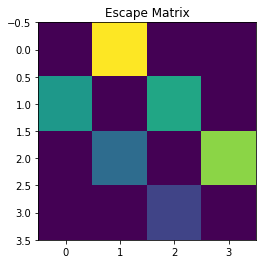

Equilibrium distribution:  ['  0.0536', '  0.1008', '  0.1681', '  0.6775']
Edge transition vector:    ['  0.3462', '  0.1831', '  0.3857']


In [63]:
(escapeMat,equilDist,Rvec)=analysis_functions.analyze_milestone1D_data(simData,winMins,winMaxs,verbose=True)

plt.imshow(escapeMat)
plt.title('Escape Matrix')
plt.show()

print 'Equilibrium distribution: ',
print map(lambda x: '%8.4f'%x,equilDist)
print 'Edge transition vector:   ',
print map(lambda x: '%8.4f'%x,Rvec)

Using the equilibrium probabilities we may recover the effective potential (PMF) over the milestoning windows as

$$\Delta G_i=-k_bT\ln{\pi_i}$$

Note: we subtract off the maximum observed energy to serve a reference potential.

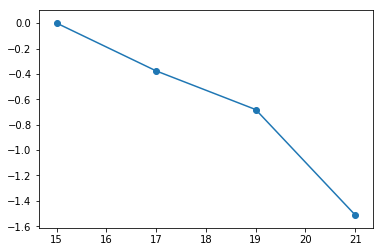

In [7]:
kbT=0.596 #boltzmann constant times temperature (300 K) in kcal/mol
gEq=-kbT*np.log(equilDist)

plt.plot(windowCenters,gEq-np.max(gEq))
plt.scatter(windowCenters,gEq-np.max(gEq))
plt.show()